<a href="https://colab.research.google.com/github/JMHunter04/sewervision/blob/main/sewervision_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install split_folders

imports libraries

In [ ]:
import tensorflow as tf #main deep learning framework
import sklearn #ML library
import splitfolders #splits a dataset folder into subfolders
import os #access to operating system
from tensorflow.keras import datasets, layers, models #keras for building and training NN
import numpy as np  #maths library for arrays
import matplotlib.pyplot as plt #visualisation
from collections import Counter #counts how many samples belong to each class
from sklearn.utils.class_weight import compute_class_weight #adds class weight command
from tensorflow.keras.metrics import AUC  #metrics for confusion matrix

goes through copied dataset and removes gdot files which had to be done as gdot files could not be processed.

In [ ]:
input_folder = "/content/drive/MyDrive/machine vision/copieddata"

In [ ]:
#does not need to be ran again
for class_dir in os.listdir(input_folder): #loop through input folder
    class_path = os.path.join(input_folder, class_dir)  #builds path to each item
    if not os.path.isdir(class_path): #skip anything thats not a folder
        continue

    for filename in os.listdir(class_path): #checks all files in folders
        if filename.startswith('.') or not filename.lower().endswith(('.jpg', '.jpeg', '.png')): #remove anything thats not
                                                                                                  #an image or any hidden files
            file_path = os.path.join(class_path, filename)
            print(f"Removing: {file_path}") #print files that are being deleted and then delete them
            os.remove(file_path)

copies dataset into new folder splitting the data into 80% training 20% test

In [ ]:
#does not need to be executed again
output = "/content/drive/MyDrive/machine vision/splitdata" #path for the new folder to store split data

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(0.8,0.2)) #uses the same randomness (42). 80/20 split

source: https://stackoverflow.com/questions/57394135/split-image-dataset-into-train-test-datasets

creates paths so that parts of dataset can be refrenced

In [ ]:
#does not need to be executed again
#create a zip of the dataset in Google Drive
!zip -r "/content/drive/MyDrive/machine_vision_dataset.zip" "/content/drive/MyDrive/machine vision/splitdata"


Scanning files .....


zip error: Interrupted (aborting)


copies zipped to local colab cache so that it is faster to refrence

In [ ]:
#copy the zip file from Drive to Colab cache
!cp "/content/drive/MyDrive/machine_vision_dataset.zip" /content/
#unzip the copied file into /content/
!unzip /content/machine_vision_dataset.zip -d /content/


In [ ]:
from google.colab import drive
drive.mount('/content/drive') #connect your Google Drive to Colab so you can read/write files there

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path   = '/content/content/drive/MyDrive/machine vision/splitdata'
train_path = '/content/content/drive/MyDrive/machine vision/splitdata/train'  #creates paths for training and testing
validity_path = '/content/content/drive/MyDrive/machine vision/splitdata/val'

creates both datasets so that all images are resized in them and uses batches as trying to train on all the images all at once breaks model, creates class names form folders

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_path, #load all images from the folder
    image_size=(240, 240),  # resizes pictures
    batch_size=32 #number of training samples processed in one go
)

val_dataset = tf.keras.utils.image_dataset_from_directory(  #same as above but for validation
    validity_path,
    image_size=(240, 240),
    batch_size=32
)

train_class = train_dataset.class_names #classes can be automatically found from folder names
print(train_class)  #creates class names from folders

val_clas = val_dataset.class_names
print(val_clas) #same but for val



creates class weights as each class does not have the same amount of pictures

In [ ]:
#collect all labels from the dataset
all_labels = []

for _, label_batch in train_dataset:

#turn the tensor into an array and add all labels in that batch to label_list
  all_labels.extend(label_batch.numpy())

#counter to count how many elements each class has
  label_counts = Counter(all_labels)

#compute weights
class_weights_array = compute_class_weight(
  class_weight = "balanced", #apply formula
  classes = np.unique(all_labels), #list of class IDs
  y = all_labels #all labels from dataset
)
  #convert to dictionary
class_weights = dict(zip(np.unique(all_labels), class_weights_array))
min_samples = 5 #sets lower limit
class_weights = {cls: (0.0 if label_counts[cls] < min_samples else np.log1p(w)) for cls,w in class_weights.items()} #uses logarithmic...
                                                                                              #...scales (stops outliers skewing weights as much)
  # prints some sample weights
for k in list(class_weights.keys())[:30]:
  print(f"Class {k}: weight {class_weights[k]:.4f}")

Class 0: weight 0.2676
Class 1: weight 0.2714
Class 2: weight 0.2485
Class 3: weight 1.0580
Class 4: weight 0.3101
Class 5: weight 2.1319
Class 6: weight 0.0000
Class 7: weight 2.0699
Class 8: weight 0.3965
Class 9: weight 0.3716
Class 10: weight 1.4448
Class 11: weight 0.5829
Class 12: weight 0.3199
Class 13: weight 0.3635
Class 14: weight 0.3251
Class 15: weight 3.6657
Class 16: weight 0.3227
Class 17: weight 0.3227
Class 19: weight 0.3169
Class 20: weight 0.3140
Class 21: weight 0.8798
Class 22: weight 2.1991
Class 23: weight 0.3173
Class 24: weight 1.7382
Class 25: weight 2.8352
Class 26: weight 3.1250
Class 27: weight 0.0000
Class 28: weight 0.0000
Class 29: weight 1.9093
Class 30: weight 1.4956


can now run

In [ ]:
train_dataset = train_dataset.shuffle(200).prefetch(tf.data.AUTOTUNE) #so that each batch sees random data
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE) #prepares next batch while on current

used to run faster

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')  #uses both 16 and 32 bit to run faster and use less memory


In [ ]:
num_classes = 75 #sets number of classes


creates CNN

In [ ]:

base_model = tf.keras.applications.EfficientNetB1(  #creates model using efficientnet
    include_top=False,  #do not include the original classificiation head
    input_shape=(240, 240, 3),  #image size
    pooling='max',      #layer that reduces dimensions whilst trying to keep important parts
    weights='imagenet'  #pretrained weights, not random initialisation
)
data_augmentation = tf.keras.Sequential([ #randomly flips, rotates and zooms images
   tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.05) #augmentations to make images more random which should result in better accuracy
])                                              #as CNN trains on more images

inputs = tf.keras.Input(shape=(240, 240, 3))

x = tf.keras.layers.Rescaling(1./255)(inputs)               #normalize
x = data_augmentation(x, training=True)                     #augmentations only applies to training
x = base_model(x, training=True)                           #use base model
x = tf.keras.layers.Dropout(0.2)(x) #randomly “drops” 20% of neurons to reduce overfitting
outputs = tf.keras.layers.Dense(num_classes, activation='softmax', dtype='float32')(x) #activation function a fully connected hidden layer,
                                                                                        #output of raw scores for 75 classes
model = tf.keras.Model(inputs=inputs, outputs=outputs) #creates model

27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
import collections
print(collections.Counter(all_labels))

Counter({np.int32(2): 1080, np.int32(0): 993, np.int32(1): 977, np.int32(56): 864, np.int32(4): 838, np.int32(20): 826, np.int32(34): 825, np.int32(19): 817, np.int32(23): 816, np.int32(40): 816, np.int32(12): 808, np.int32(72): 807, np.int32(39): 804, np.int32(16): 800, np.int32(17): 800, np.int32(32): 799, np.int32(14): 793, np.int32(57): 772, np.int32(13): 695, np.int32(9): 677, np.int32(38): 664, np.int32(8): 626, np.int32(11): 385, np.int32(44): 322, np.int32(45): 283, np.int32(31): 267, np.int32(63): 224, np.int32(21): 216, np.int32(55): 186, np.int32(3): 162, np.int32(67): 158, np.int32(69): 144, np.int32(53): 143, np.int32(68): 132, np.int32(41): 120, np.int32(74): 101, np.int32(10): 94, np.int32(30): 88, np.int32(71): 87, np.int32(33): 83, np.int32(47): 75, np.int32(24): 65, np.int32(43): 56, np.int32(50): 54, np.int32(29): 53, np.int32(59): 53, np.int32(49): 48, np.int32(7): 44, np.int32(62): 41, np.int32(5): 41, np.int32(70): 39, np.int32(22): 38, np.int32(51): 37, np.int32(

In [ ]:
for images, labels in train_dataset.take(1):
    print("Train batch shape:", images.shape)
    print("Train labels:", labels.numpy())

for images, labels in val_dataset.take(1):
    print("Train batch shape:", images.shape)
    print("Train labels:", labels.numpy())


Train batch shape: (32, 240, 240, 3)
Train labels: [41 54 34 55 19 14 16 43 56 34 20 12 12 19 16 20 20  3 48 21 32 56  9 69
 14 14 11 17 23 14  8 30]
Train batch shape: (32, 240, 240, 3)
Train labels: [45 34 19 19 14 39 23  0 39 39 14 38 32 56 37 56  9 31 17 34 12 23 16 38
 20 41 12 43  1 56 20 53]


reduce LR on plateau

In [ ]:

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', #monitors validity accuracy
    factor=0.5,    #halve learning rate
    patience=3,    #wait 2 epochs of no improvement
    min_lr=1e-6,  #don’t go below this
    min_delta=0.01 #ignore small changes
)


In [ ]:
#callbacks
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.90):
      print("\nReached 90% accuracy so cancelling training!") #once validation accuracy reaches 90% stops training
      self.model.stop_training = True

callbacks = [myCallback(), reduce_lr]

compiles model

In [ ]:

model.compile(
    optimizer='adam', #optimiser for deep learning
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), #softmax already turned on in dense layer
    metrics=['accuracy']
)

history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=40,
                    class_weight = class_weights,
                    callbacks=[callbacks])

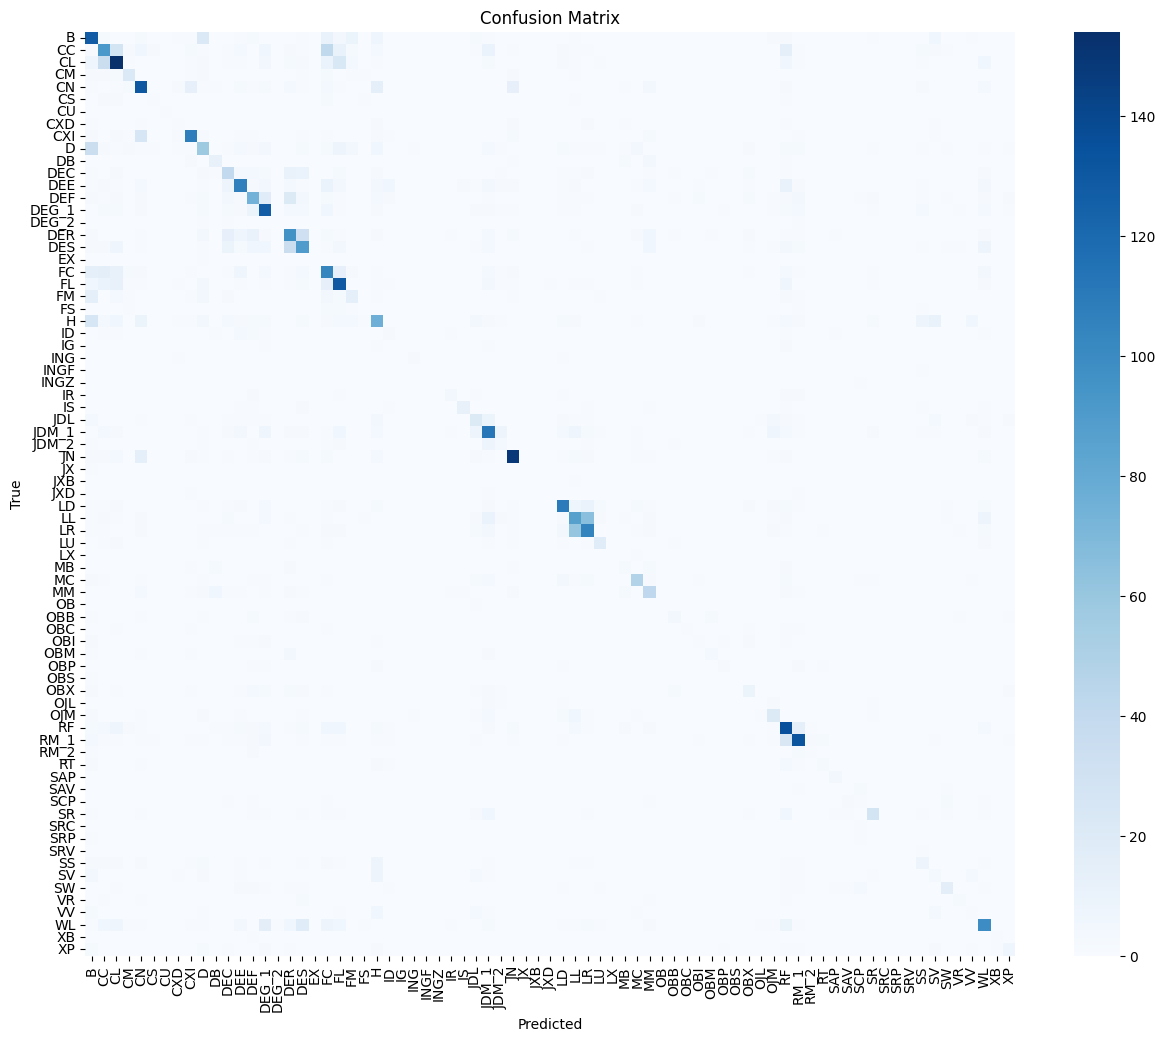

              precision    recall  f1-score   support

           B       0.44      0.60      0.51       212
          CC       0.46      0.38      0.41       245
          CL       0.57      0.57      0.57       271
          CM       0.55      0.54      0.54        41
          CN       0.58      0.62      0.60       210
          CS       0.20      0.09      0.12        11
          CU       1.00      1.00      1.00         1
         CXD       0.09      0.08      0.09        12
         CXI       0.74      0.69      0.71       157
           D       0.41      0.34      0.37       170
          DB       0.46      0.50      0.48        24
         DEC       0.39      0.41      0.40        97
         DEE       0.59      0.53      0.56       203
         DEF       0.50      0.43      0.46       174
       DEG_1       0.52      0.64      0.57       199
       DEG_2       0.00      0.00      0.00         3
         DER       0.46      0.48      0.47       201
         DES       0.44    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


#get true labels and predictions for val
y_true = []
y_pred = []

for images, labels in val_dataset:
    preds = model.predict(images, verbose=0)  #predictions
    y_true.extend(labels.numpy())              #true labels
    y_pred.extend(np.argmax(preds, axis=1))    #predicted class indices

y_true = np.array(y_true)
y_pred = np.array(y_pred)
#compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
#plot
plt.figure(figsize=(15, 12))
sns.heatmap(cm,
            annot=False,
            cmap="Blues", #colour
            xticklabels=train_class,
            yticklabels=train_class,
            cbar=True)
plt.xlabel("Predicted") #labels
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

#prints classification report for an alternative way to view
print(classification_report(y_true, y_pred, target_names=train_class))


In [ ]:
#train vs val loss

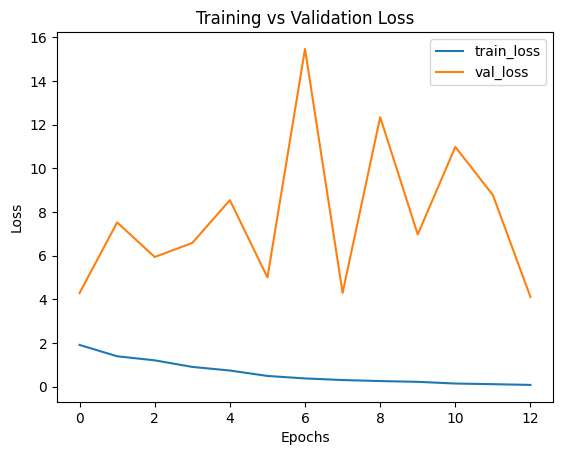

In [ ]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


train vs val accuracy

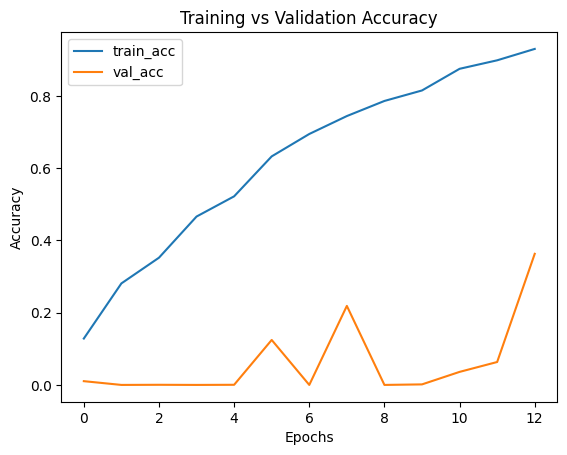

In [ ]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()
